# Solving the [8-puzzle](https://8-puzzle.readthedocs.io/en/latest/) (with a slight twist)
## Testing which heuristics perform best on for the competition


Instead of only being able to slide tiles vertically and horizontally (with a cost of 1), when the empty tile is at a corner, the tiles on the same row (or on the same column) can wrap around (if you have more than two rows) with a cost of 2. Similarly the diagonal tiles (both the adjacent one and the opposing corner) can slide into an empty corner with a cost of 3. We use the number 0 to represent the empty tile.

In [7]:
# you need to install these in your env to run this notebook
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import copy

# local modules, no installs needed
import run
from board import Board
from node import Node
import search
from heuristics import hamming_distance, manhattan_distance, row_col_out_of_place, euclidean_distance, permutation_inversion



In [9]:
HEURISTICS = [hamming_distance, manhattan_distance, row_col_out_of_place, euclidean_distance, permutation_inversion]

COMPETITION_PUZZLE_FILENAME = 'competitionPuzzles.txt'

puzzles = run.convert_to_numpy_arrays(COMPETITION_PUZZLE_FILENAME)

puzzles = [p.reshape(2,4) for p in puzzles]

print(f'These are the {len(puzzles)} competition puzzles:')
for p in puzzles:
    print(f'-\n{p}')


These are the 25 competition puzzles:
-
[[7 5 1 6]
 [0 2 4 3]]
-
[[2 4 7 3]
 [6 5 1 0]]
-
[[7 2 6 0]
 [3 4 1 5]]
-
[[6 3 0 5]
 [4 2 1 7]]
-
[[7 2 6 4]
 [3 0 1 5]]
-
[[7 4 1 5]
 [3 2 6 0]]
-
[[3 0 1 4]
 [2 6 5 7]]
-
[[4 5 3 6]
 [2 0 7 1]]
-
[[3 4 0 1]
 [5 7 6 2]]
-
[[6 3 4 7]
 [1 2 5 0]]
-
[[3 5 7 2]
 [4 6 0 1]]
-
[[1 0 3 6]
 [5 2 7 4]]
-
[[2 7 3 0]
 [6 1 4 5]]
-
[[6 3 1 5]
 [7 4 2 0]]
-
[[7 1 5 4]
 [3 0 2 6]]
-
[[7 4 0 3]
 [5 2 6 1]]
-
[[2 3 7 6]
 [5 0 4 1]]
-
[[6 1 5 0]
 [3 2 4 7]]
-
[[4 3 5 0]
 [2 6 1 7]]
-
[[0 4 5 7]
 [2 6 1 3]]
-
[[2 5 6 7]
 [3 4 1 0]]
-
[[7 1 6 5]
 [0 2 4 3]]
-
[[7 6 0 3]
 [4 1 5 2]]
-
[[7 6 4 5]
 [3 2 1 0]]
-
[[7 3 6 5]
 [1 4 2 0]]


In [11]:
def build_experiment_object():
    '''Build's the structure that will run the experiment and hold results'''
    experiment = {}
    for func in HEURISTICS:
        experiment[func.__name__] = {
            'func': func,
            'algos': {
                'GBF': {
                    'func': search.greedy_best_first,
                    'shape': {
                        (2, 4): {'results': []},
                        (3, 3): {'results': []}
                    }
                },
                'A*': {
                    'func': search.a_star,
                    'shape': {
                        (2, 4): {'results': []},
                        (3, 3): {'results': []}
                    }
                }
            },
        }

    return experiment

experiment = build_experiment_object()

In [13]:
def run_experiment(experiment: dict, puzzles: list):
    for heurist_name in tqdm(experiment):
        heuristic_func = experiment[heurist_name]['func']

        for algo_name in experiment[heurist_name]['algos']:
            algo_func = experiment[heurist_name]['algos'][algo_name]['func']

            for puzzle in puzzles:
                b = Board(puzzle)
                result: dict = algo_func(board=b, H=heuristic_func)
                experiment[heurist_name]['algos'][algo_name]['shape'][puzzle.shape]['results'].append(result)

    return experiment

In [15]:

print(f'\nRunning 2 search algorithms on {len(puzzles)} puzzles, 5 different times to test the 5 heuristics:')
start = time.time()

run_experiment(experiment,puzzles)

elapsed = round(time.time()-start, 2)
print(f'\n\nTotal of 2x{len(puzzles)}x5 = {2*len(puzzles)*5} puzzles solved in {elapsed} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]
Running 2 search algorithms on 25 puzzles, 5 different times to test the 5 heuristics:
100%|██████████| 5/5 [00:55<00:00, 11.02s/it]

Total of 2x25x5 = 250 puzzles solved in 55.12 seconds



In [17]:
def generate_stats(experiment):
    prototype = {
        'GBF': {
            'hamming_distance': {},
            'manhattan_distance': {},
            'row_col_out_of_place': {},
            'euclidean_distance': {},
            'permutation_inversion': {}
        },
        'A*': {
            'hamming_distance': {},
            'manhattan_distance': {},
            'row_col_out_of_place': {},
            'euclidean_distance': {},
            'permutation_inversion': {}
        }
    }
    global_stats = {
        (2,4): copy.deepcopy(prototype),
        (3,3): copy.deepcopy(prototype),
        }
    stats = {}
    timeouts = 0
    result_count = 0

    for heuristic in experiment:

        for algo in experiment[heuristic]['algos']:
            
            for shape in experiment[heuristic]['algos'][algo]['shape']:

                results = experiment[heuristic]['algos'][algo]['shape'][shape]['results']
                
                runtimes = [r['runtime'] for r in results]
                costs = np.array([r['current_node'].total_cost for r in results])
                num_visited_nodes = np.array([r['visited_nodes'] for r in results])
                
                mean_runtime = np.mean(runtimes)
                mean_cost = np.mean(costs)
                mean_vis_nodes = np.mean(num_visited_nodes)
                
                global_stats[shape][algo][heuristic]['mean_runtime'] = mean_runtime
                global_stats[shape][algo][heuristic]['mean_cost'] = mean_cost
                global_stats[shape][algo][heuristic]['mean_visited_nodes'] = mean_vis_nodes
                global_stats[shape][algo][heuristic]['std_runtime'] = np.std(runtimes)
                global_stats[shape][algo][heuristic]['std_cost'] = np.std(costs)
                global_stats[shape][algo][heuristic]['std_visited_nodes'] = np.std(num_visited_nodes)
                
                timeouts += len([1 for r in results if not r['success']])
    
    print(f'number of timeouts = {timeouts}.')

    return global_stats


In [ ]:
stats = generate_stats(experiment)
'''here is a small sample of what the stats object looks like'''
stats[(2,4)]['GBF']['hamming_distance']

### Let us now compare these heuristics.

In [12]:
'''Calculating average runtime for each heuristic'''
def plot_stats(stats, shape, algo):
    
    heuris_vs_runtime = {}
    heuris_vs_cost = {}
    heuris_vs_visited = {}

    for heuristic in stats[shape][algo]:
        alias = stats[shape][algo][heuristic]
        heuris_vs_runtime[heuristic] = round(alias['mean_runtime'], 2)
        heuris_vs_cost[heuristic] = round(alias['mean_cost'], 2) 
        heuris_vs_visited[heuristic] = round(alias['mean_visited_nodes'], 2)
    
    print(heuris_vs_runtime)
    plt.barh(tuple(heuris_vs_runtime.keys()),heuris_vs_runtime.values())
    plt.ylabel('Heuristics')
    plt.xlabel('Time in Seconds')
    plt.title(f'Mean runtime of {algo} on {shape[0]}x{shape[1]} puzzles')
    plt.show()
    print()

    print(heuris_vs_cost)
    plt.barh(tuple(heuris_vs_cost.keys()),heuris_vs_cost.values())
    plt.ylabel('Heuristics')
    plt.xlabel('Cost')
    plt.title(f'Mean cost of {algo} on {shape[0]}x{shape[1]} puzzles')
    plt.show()
    print()
    
    print(heuris_vs_visited)
    plt.barh(tuple(heuris_vs_visited.keys()),heuris_vs_visited.values())
    plt.ylabel('Heuristics')
    plt.xlabel('Number of Visited Nodes')
    plt.title(f'Mean search path of {algo} on {shape[0]}x{shape[1]} puzzles')
    plt.show()


    

{'hamming_distance': 0.31, 'manhattan_distance': 0.1, 'row_col_out_of_place': 0.24, 'euclidean_distance': 0.26, 'permutation_inversion': 0.33}


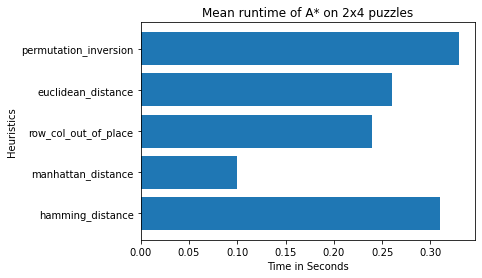


{'hamming_distance': 13.36, 'manhattan_distance': 13.4, 'row_col_out_of_place': 13.36, 'euclidean_distance': 13.32, 'permutation_inversion': 15.88}


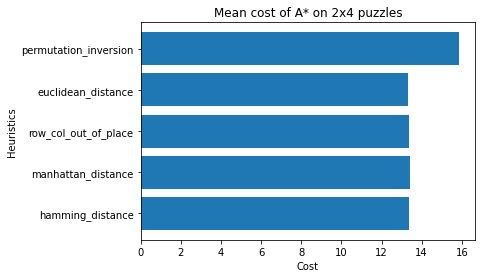


{'hamming_distance': 928.76, 'manhattan_distance': 130.84, 'row_col_out_of_place': 349.56, 'euclidean_distance': 291.0, 'permutation_inversion': 316.68}


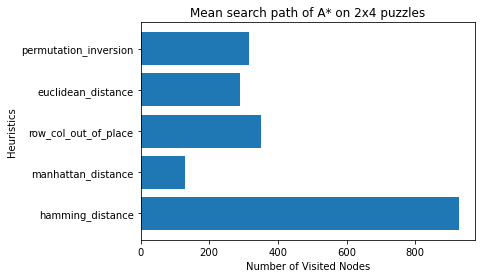

In [14]:
plot_stats(stats,(2,4),'A*')

{'hamming_distance': 0.01, 'manhattan_distance': 0.05, 'row_col_out_of_place': 0.03, 'euclidean_distance': 0.07, 'permutation_inversion': 0.34}


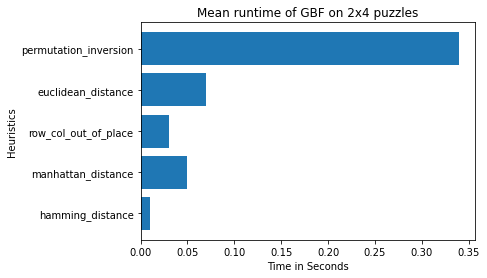


{'hamming_distance': 22.72, 'manhattan_distance': 23.92, 'row_col_out_of_place': 21.48, 'euclidean_distance': 30.04, 'permutation_inversion': 30.96}


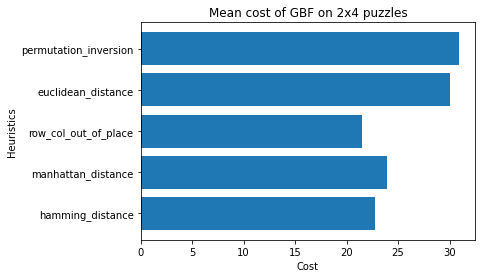


{'hamming_distance': 67.8, 'manhattan_distance': 92.32, 'row_col_out_of_place': 96.16, 'euclidean_distance': 149.12, 'permutation_inversion': 701.0}


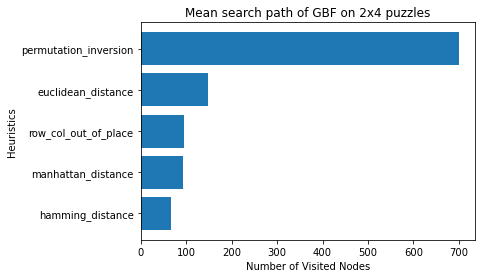

In [16]:
plot_stats(stats,(2,4),'GBF')

### Let's check how our heuristic cost solutions compares to the ideal cost solutions

In [20]:
for i, p in enumerate(puzzles):
    result = search.uniform_cost(Board(p))
    print(f"puzzle {i+1}: \tcost: {result['current_node'].total_cost} \tfound in {result['runtime']} seconds")

puzzle 1: 	smallest cost solution is 16 	found in 10.55 seconds
puzzle 2: 	smallest cost solution is 14 	found in 3.93 seconds
puzzle 3: 	smallest cost solution is 14 	found in 3.0 seconds
puzzle 4: 	smallest cost solution is 15 	found in 5.61 seconds
puzzle 5: 	smallest cost solution is 17 	found in 11.18 seconds
puzzle 6: 	smallest cost solution is 13 	found in 2.02 seconds
puzzle 7: 	smallest cost solution is 13 	found in 3.09 seconds
puzzle 8: 	smallest cost solution is 13 	found in 2.58 seconds
puzzle 9: 	smallest cost solution is 15 	found in 11.97 seconds
puzzle 10: 	smallest cost solution is 12 	found in 2.55 seconds
puzzle 11: 	smallest cost solution is 11 	found in 0.68 seconds
puzzle 12: 	smallest cost solution is 9 	found in 0.64 seconds
puzzle 13: 	smallest cost solution is 13 	found in 4.34 seconds
puzzle 14: 	smallest cost solution is 17 	found in 23.51 seconds
puzzle 15: 	smallest cost solution is 15 	found in 11.71 seconds
puzzle 16: 	smallest cost solution is 13 	foun